In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Mesh size : 1000000
Extra memory(%)      : 0.08
Extra memory(float64): 4000.0
Extra memory(Kbytes) : 250.0


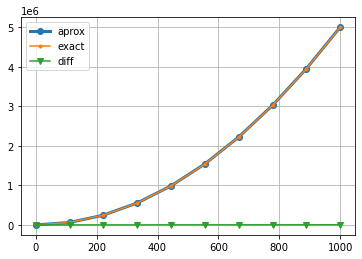

In [2]:
X = 1000
N = 10
x = np.linspace(0,X,N)
y1 = 5 * x * x
y2 = 5 * x * x - 4 * x
ea= y1 - y2
diff = y1[-1]-y2[-1]
print('Mesh size :', X * X)
print('Extra memory(%)      :', 100 * diff / np.max(y1))
print('Extra memory(float64):', diff)
print('Extra memory(Kbytes) :', diff * 8 * 8 / 1024)
plt.plot(x, y1,'-o', lw=3, label='aprox')
plt.plot(x, y2,'.-', label='exact')
plt.plot(x, ea,'-v', label='diff')
plt.grid()
plt.legend()

Mesh size : 1000000000
Extra memory(%)      : 0.08571428571428572
Extra memory(float64): 6000000.0
Extra memory(Kbytes) : 366.2109375


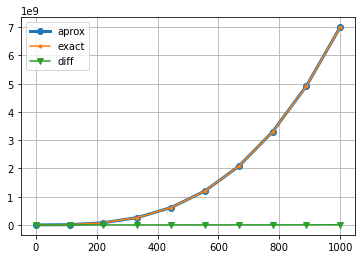

In [3]:
y3 = 7 * x * x * x
y4 = 7 * x * x * x - 6 * x * x
ea = y3 - y4
diff = y3[-1]-y4[-1]
print('Mesh size :', X * X * X)
print('Extra memory(%)      :', 100 * diff / np.max(y3))
print('Extra memory(float64):', diff)
print('Extra memory(Kbytes) :', diff * 8 * 8 / (1024 * 1024))

plt.plot(x, y3,'-o', lw=3, label='aprox')
plt.plot(x, y4,'.-', label='exact')
plt.plot(x, ea,'-v', label='diff')
plt.grid()
plt.legend()

In [14]:
def aS(i,j):
    return 1 #4

def aW (i,j):
    return 1 #2

def aP(i,j):
    return -4 

def aE(i,j):
    return 1 #3

def aN(i,j):
    return 1 #5

In [15]:
Nx = 2 # 0, 1, 2
Ny = 3 # 0, 1, 2, 3

print(Nx, Ny)

bi = 0
ei = Nx
bj = 0
ej = Ny

NTx = ei - bi + 1
NTy = ej - bj + 1

print(NTx, NTy)

Nd = 5

N = NTx * NTy
print(N)
Nzeros = Nd * N
print(Nzeros)

AA = np.zeros(Nzeros)
JA = np.zeros(Nzeros, dtype=int)
IA = np.zeros(N+1, dtype=int)

print(Nzeros * 2 + N+1)
print(N * N)

2 3
3 4
12
60
133
144


In [16]:
def print_csr(AA,JA,IA,Nd, nice = False):
    N = len(IA)-1
    if not(nice):
        I = 0
        print('-' * 52)
        print('|{:>3} | {:>3} | {:>5} | {:>5} {:>5} {:>5} {:>5} {:>5} |'.format('I','IA','','S','W','P','E','N'))
        print('-' * 52)
        for i in range(0,N):
            print('|{:>3} | {:>3} | AA -> | {:>5} {:>5} {:>5} {:>5} {:>5} |'.format(i, IA[i], AA[I], AA[I+1], AA[I+2], AA[I+3], AA[I+4]))
            print('|{:>3} | {:>3} | JA -> | {:>5} {:>5} {:>5} {:>5} {:>5} |'.format(i, IA[i],JA[I], JA[I+1], JA[I+2], JA[I+3], JA[I+4]))
            print('-' * 52)
            I += Nd
    else:
        AT = np.zeros((N,N))
        for i in range(0,N):
            for j in range(IA[i],IA[i+1]):
                AT[i,JA[j]] = AA[j]
        print(AT)

        
        

In [19]:
def csr_matrix(AA, JA, IA, cotas, Nd):
#
# Compressed Sparse Row (CSR) or Compressed Row Storage (CRS)
#
    I = 0
    irow = 0
    IA[irow] = I
    bi = cotas[0]
    ei = cotas[1]
    bj = cotas[2]
    ej = cotas[3]
    NTx = ei - bi + 1
    NTy = ej - bj + 1
#    
# FILL THE MATRIX WITH ALL DIAGONALS EQUAL IN SIZE.
#-----------+
# S W P E N |
# S W P E N |
# S W P E N |
# ...       
# S W P E N |
# S W P E N |
#-----------+    
    for j in range(bj,ej+1):
        for i in range(bi,ei+1):
            # S
            AA[I] = aS(i,j)
            JA[I] = irow - NTx
        
            # W
            I += 1 
            AA[I] = aW(i,j)
            JA[I] = irow - 1
        
            # P
            I += 1 
            AA[I] = aP(i,j)
            JA[I] = irow
        
            # E
            I += 1
            AA[I] = aE(i,j)
            JA[I] = irow + 1
        
            #N
            I += 1
            AA[I] = aN(i,j)
            JA[I] = irow + NTx
        
            # FILL IA ARRAY
            I += 1
            irow += 1
            IA[irow] = I   
            
    return 0

In [17]:
def correct_csr(AA,JA,IA,cotas,Nd):
    bi = cotas[0]
    ei = cotas[1]
    bj = cotas[2]
    ej = cotas[3]
    NTx = ei - bi + 1
    NTy = ej - bj + 1
#    
# CORRECT THE FIRST AND LAST BLOCK OF THE MATRIX
#-----------+
# 0 W P E N |
# 0 W P E N |  FIRST BLOCK
# 0 W P E N |
#-----------
# ...   
#-----------
# S W P E 0 |
# S W P E 0 |  LAST BLOCK
# S W P E 0 |
#-----------+
# PUT ZEROS IN PLACES CORRESPONDING TO S AND N
#
    I = 0
    OFFSET = (NTy - 1) * NTx
    
    for i in range(NTx):
        # FIRST BLOCK
        AA[IA[I]] = 0
        JA[IA[I]] = 0 # to avoid outbounds
        
        # LAST BLOCK
        AA[IA[I+OFFSET] + Nd - 1] = 0
        JA[IA[I+OFFSET] + Nd - 1] = 0 # to avoid outbounds        

        I += 1
#
# CORRECT THE FIRST AND LAST ROWS OF EACH BLOCK
#-----------
# S * P E N |
# S W P E N | ANY BLOCK
# S W P * N |
#-----------+
# PUT ZEROS IN PLACES CORRESPONDING TO W AND E
#
    for j in range(NTy):
        # FIRST ROW OF EACH BLOCK
        I = IA[NTx*j] + 1 # W
        AA[I] = 0
        
        # LAST ROW OF EACH BLOCK
        I = IA[NTx*(j+1)] - 2 # E
        AA[I] = 0

# To avoid outbounds in first and last row of storage.
    JA[ 1] = 0 # First row   
    JA[-2] = 0 # Last row
    
    return 0

In [23]:
cotas = (bi,ei,bj,ej)
csr_matrix(AA,JA,IA,cotas,Nd)
correct_csr(AA,JA,IA,cotas,Nd)
print_csr(AA,JA,IA,Nd, nice=False)

----------------------------------------------------
|  I |  IA |       |     S     W     P     E     N |
----------------------------------------------------
|  0 |   0 | AA -> |   0.0   0.0  -4.0   1.0   1.0 |
|  0 |   0 | JA -> |     0     0     0     1     3 |
----------------------------------------------------
|  1 |   5 | AA -> |   0.0   1.0  -4.0   1.0   1.0 |
|  1 |   5 | JA -> |     0     0     1     2     4 |
----------------------------------------------------
|  2 |  10 | AA -> |   0.0   1.0  -4.0   0.0   1.0 |
|  2 |  10 | JA -> |     0     1     2     3     5 |
----------------------------------------------------
|  3 |  15 | AA -> |   1.0   0.0  -4.0   1.0   1.0 |
|  3 |  15 | JA -> |     0     2     3     4     6 |
----------------------------------------------------
|  4 |  20 | AA -> |   1.0   1.0  -4.0   1.0   1.0 |
|  4 |  20 | JA -> |     1     3     4     5     7 |
----------------------------------------------------
|  5 |  25 | AA -> |   1.0   1.0  -4.0   0.0  

In [24]:
print(AA)

[ 0.  0. -4.  1.  1.  0.  1. -4.  1.  1.  0.  1. -4.  0.  1.  1.  0. -4.
  1.  1.  1.  1. -4.  1.  1.  1.  1. -4.  0.  1.  1.  0. -4.  1.  1.  1.
  1. -4.  1.  1.  1.  1. -4.  0.  1.  1.  0. -4.  1.  0.  1.  1. -4.  1.
  0.  1.  1. -4.  0.  0.]


In [25]:
print(JA)

[ 0  0  0  1  3  0  0  1  2  4  0  1  2  3  5  0  2  3  4  6  1  3  4  5
  7  2  4  5  6  8  3  5  6  7  9  4  6  7  8 10  5  7  8  9 11  6  8  9
 10  0  7  9 10 11  0  8 10 11  0  0]


In [26]:
print(IA)

[ 0  5 10 15 20 25 30 35 40 45 50 55 60]


In [27]:
def matvec(AA, JA, IA, x):
    N = len(IA)-1
    y = np.zeros(N)
    for i in range(0,N):
        y[i] = 0
        for j in range(IA[i],IA[i+1]):
            y[i] = y[i] + AA[j] * x[JA[j]]
    return y

In [28]:
vec = np.ones(N)
matvec(AA,JA,IA,vec)

array([-2., -1., -2., -1.,  0., -1., -1.,  0., -1., -2., -1., -2.])